# Gaining Early Insights from Textual Data

# Exploratory Data Analysis


# Introducing the Dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# suppress warnings
import warnings;
warnings.filterwarnings('ignore');

# common imports
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging

import spacy
import nltk

from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# pandas display options
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#available-options
pd.options.display.max_columns = 30 # default 20
pd.options.display.max_rows = 60 # default 60
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.precision = 2
pd.options.display.max_colwidth = 200 # default 50; -1 = all
# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# np.set_printoptions(edgeitems=3) # default 3

import matplotlib
from matplotlib import pyplot as plt

plot_params = {'figure.figsize': (8, 4),
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

import seaborn as sns
sns.set_style("darkgrid")


In [3]:
BASE_DIR = '/content/drive/MyDrive/ESCP/NLP/01_Text_Statistics/data'
os.chdir(BASE_DIR)

In [4]:
pd.options.display.max_colwidth = 150 ###
file = "un-general-debates-blueprint.csv.gz"
df = pd.read_csv(file)
df.sample(2, random_state=53)

,session,year,country,country_name,speaker,position,text
3871,51,1996,PER,Peru,Francisco Tudela Van Breughel Douglas,Minister for Foreign Affairs,"﻿At the outset, allow me,\nSir, to convey to you and to this Assembly the greetings\nand congratulations of the Peruvian people, as well as\ntheir..."
4697,56,2001,GBR,United Kingdom,Jack Straw,Minister for Foreign Affairs,"﻿Please allow me\nwarmly to congratulate you, Sir, on your assumption of\nthe presidency of the fifty-sixth session of the General\nAssembly.\nThi..."


# Getting an Overview of the Data with Pandas


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 232.1 MB


In [6]:
df.dtypes

session          int64
year             int64
country         object
country_name    object
speaker         object
position        object
text            object
dtype: object

In [7]:
df.columns

Index(['session', 'year', 'country', 'country_name', 'speaker', 'position',
       'text'],
      dtype='object')

In [8]:
df.count()

session         7507
year            7507
country         7507
country_name    7507
speaker         7480
position        4502
text            7507
dtype: int64

## Calculating Summary Statistics for Columns


In [9]:
df['text'].apply(len).equals(df['text'].str.len())

True

In [10]:
df['text'].map(len).equals(df['text'].str.len())

True

In [11]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.00,49.61,12.89,25.00,39.00,51.00,61.00,70.00
year,7507.00,1994.61,12.89,1970.00,1984.00,1996.00,2006.00,2015.00
length,7507.00,17967.28,7860.04,2362.00,12077.00,16424.00,22479.50,72041.00


In [12]:
df[['country', 'speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


In [13]:
df[['country', 'speaker']].groupby('country').count()


,speaker
country,
AFG,45
AGO,38
ALB,46
AND,22
ARE,44
...,...
YEM,45
YUG,37
ZAF,26


In [14]:
df.nunique()

session           46
year              46
country          199
country_name     199
speaker         5428
position         113
text            7507
length          6458
dtype: int64

## Checking for Missing Data


In [15]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [16]:
df['speaker'].fillna('unknown', inplace=True)

In [17]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

In [18]:
df.loc[df['speaker'].str.contains('Bush'), 'speaker'].value_counts()



George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

## Plotting Value Distributions


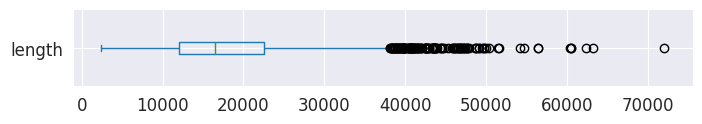

In [19]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1)) ;

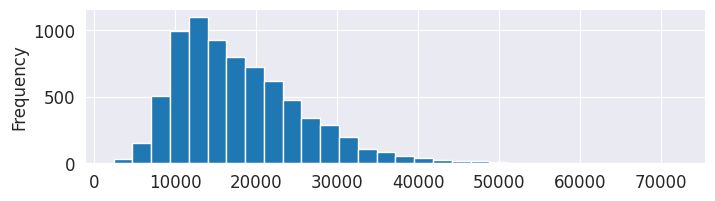

In [20]:
df['length'].plot(kind='hist', bins=30, figsize=(8,2));

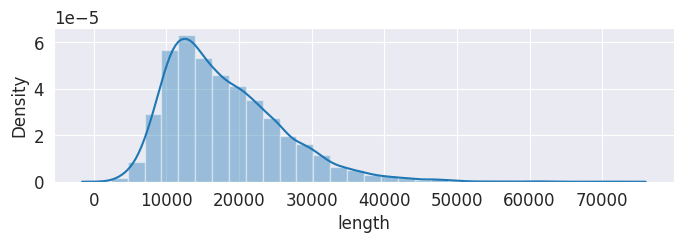

In [21]:
plt.figure(figsize=(8, 2))
sns.distplot(df['length'], bins=30, kde=True);

## Comparing Value Distributions across Categories


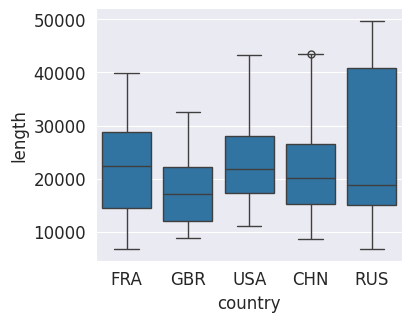

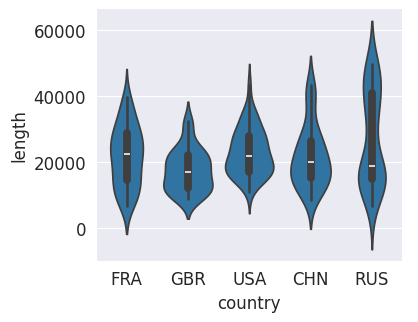

In [22]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="length", kind='box')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###
g = sns.catplot(data=df[where], x="country", y="length", kind='violin')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###

In [23]:
df.loc[where, ["country","length"]].groupby("country").describe()

length                                                               
         count     mean      std      min      25%      50%      75%      max
country                                                                      
CHN      45.00 21917.20  9373.42  8609.00 15298.00 20089.00 26575.00 43499.00
FRA      46.00 21858.24  9029.71  6714.00 14530.25 22454.50 28855.25 39887.00
GBR      46.00 17672.76  6333.21  8833.00 12121.50 17070.50 22160.75 32495.00
RUS      45.00 27100.18 14082.04  6804.00 15090.00 18873.00 40922.00 49700.00
USA      46.00 23190.39  7017.58 11105.00 17223.50 21918.50 28029.50 43287.00

## Visualizing Developments over Time


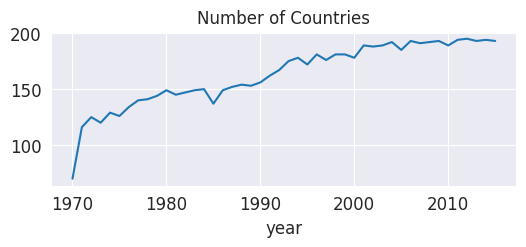

In [24]:
df.groupby('year')['country'].count().plot(title="Number of Countries", figsize=(6,2));

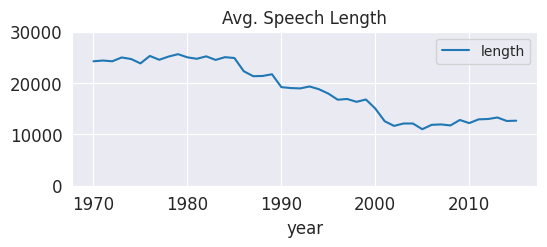

In [25]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2));

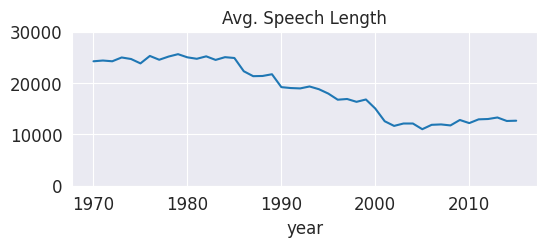

In [26]:
df.groupby('year')['length'].mean().plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2));

# Building a Simple Text Preprocessing Pipeline


## Tokenization with Regular Expressions


In [27]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [28]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


## Treating Stop Words


In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [31]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [32]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [33]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Processing a Pipeline with one Line of Code


In [34]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
  tokens = text
  for transform in pipeline:
      tokens = transform(tokens)
  return tokens

In [35]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [36]:
df['num_tokens'] = df['tokens'].progress_map(len)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [37]:

df.head(3)

,session,year,country,country_name,speaker,position,text,length,tokens,num_tokens
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth sessi...,51419,"[may, first, convey, president, congratulations, albanian, delegation, election, presidency, twenty-fifth, session, general, assembly, taking, wor...",4125
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,"177.\t : It is a fortunate coincidence that precisely at a time when the United Nations is celebrating its first twenty-five years of existence, a...",29286,"[fortunate, coincidence, precisely, time, united, nations, celebrating, first, twenty-five, years, existence, eminent, jurist, closely, linked, or...",2327
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,"100.\t It is a pleasure for me to extend to you, Mr. President, the warmest congratulations of the Australia Government and its delegation to thi...",31839,"[pleasure, extend, mr, president, warmest, congratulations, australia, government, delegation, general, assembly, election, presidency, distinguis...",2545


# Word Frequency Analysis


## Counting Words with a Counter


In [38]:

from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")
print(tokens)

counter = Counter(tokens)
print(counter)

['She', 'likes', 'my', 'cats', 'and', 'my', 'cats', 'like', 'my', 'sofa']
Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [39]:
more_tokens = tokenize("She likes dogs and cats.")
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [40]:
counter = Counter()

_ = df['tokens'].map(counter.update)

In [41]:
pp.pprint(counter.most_common(5))

[('nations', 124508),
 ('united', 120763),
 ('international', 117223),
 ('world', 89421),
 ('countries', 85734)]


In [42]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [43]:
freq_df = count_words(df)
freq_df.head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [44]:
# top words with 10+ characters
count_words(df, column='text',
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177


## Creating a Frequency Diagram


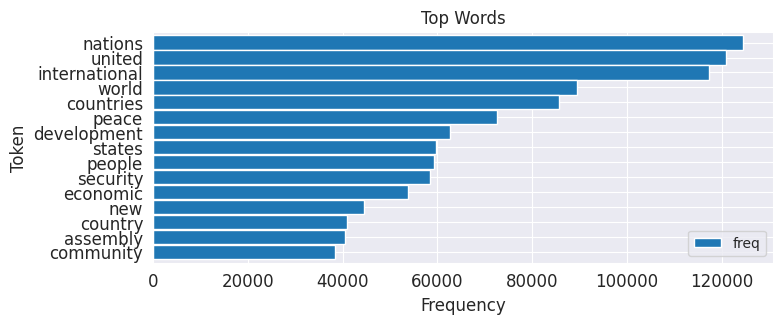

In [45]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words');

## Creating Word Clouds


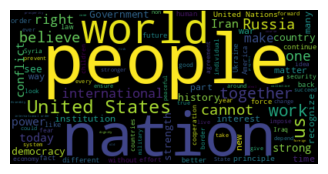

In [46]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = df.query("year==2015 and country=='USA'")['text'].values[0]

plt.figure(figsize=(4, 2)) ###
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

  0%|          | 0/193 [00:00<?, ?it/s]

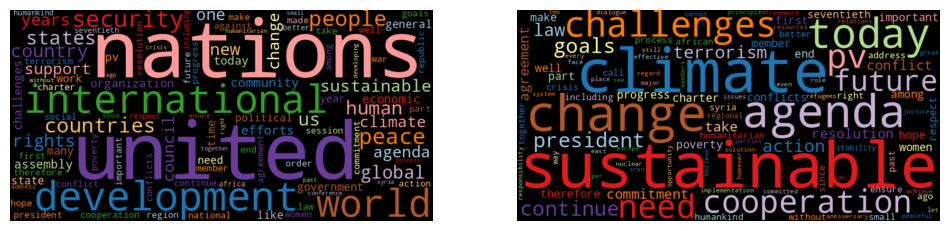

In [48]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

## Ranking with TF-IDF


In [49]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [51]:
idf_df = compute_idf(df)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [52]:
idf_df.sample(5, random_state = 42)

,df,idf
token,,
reminders,50,5.11
fissure,3,7.92
-share,2,8.33
deserves,1157,1.97
exclusions,25,5.80


In [53]:
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

In [54]:
freq_df.head(3)

,freq,df,idf,tfidf
token,,,,
nations,124508,7495.00,0.10,12649.99
united,120763,7494.00,0.10,12285.61
international,117223,7466.00,0.11,12364.28


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

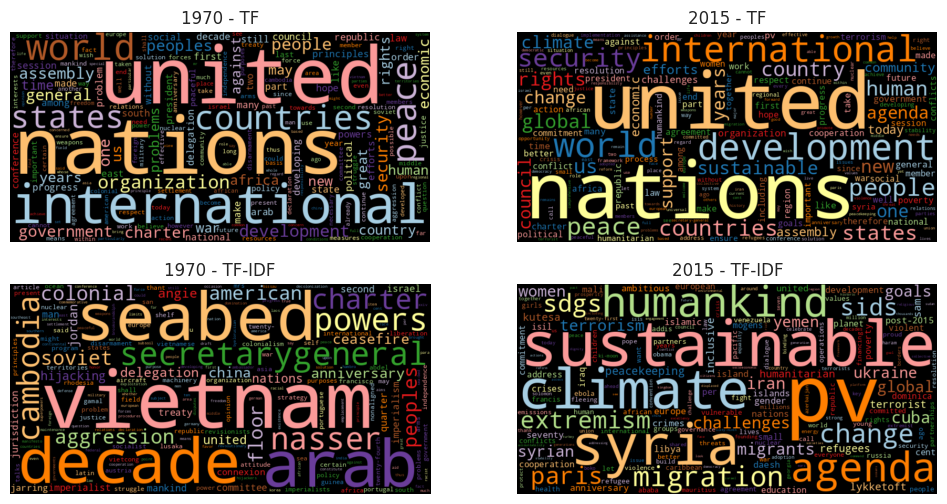

In [55]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_1970['freq'], title='1970 - TF',
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_2015['freq'], title='2015 - TF',
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF',
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF',
          stopwords=['seventieth'])

# Finding a Keyword in Context (KWIC)


**Note:** textacy's API had major changes from version 0.10.1 (as used in the book) to 0.11.  
Here, `textacy.text_utils.KWIC` became `textacy.extract.kwic.keyword_in_context` (see [textacy documentation](https://textacy.readthedocs.io/en/latest/api_reference/extract.html#module-textacy.extract.kwic)).




In [56]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [57]:
try:
  import textacy
except:
  !pip install textacy
  import textacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.8 MB/s eta 0:00:00


In [58]:
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC

else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args,
                           **{kw: arg for kw, arg in kwargs.items()
                            if kw != 'print_only'})

In [59]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True,
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [60]:

random.seed(22) ###
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

  0%|          | 0/193 [00:00<?, ?it/s]

5 random samples out of 73 contexts for 'sdgs':
 of our planet and its people. The   SDGs   are a tangible manifestation of th
nd, we are expected to achieve the   SDGs   and to demonstrate dramatic develo
ead by example in implementing the   SDGs   in Bangladesh. Attaching due impor
the Sustainable Development Goals (  SDGs  ). We applaud all the Chairs of the
new Sustainable Development Goals (  SDGs  ) aspire to that same vision. The A


# Analyzing N-Grams


In [61]:
tokens = ["Sustainable", "Development", "Goals"]
print(*[tokens[i:] for i in range(2)])

['Sustainable', 'Development', 'Goals'] ['Development', 'Goals']


In [62]:
tokens = ["Sustainable", "Development", "Goals"]
print([' '.join(z) for z in zip(*[tokens[i:] for i in range(2)])])

['Sustainable Development', 'Development Goals']


In [63]:
z = zip(['Sustainable', 'Development', 'Goals'],['Development', 'Goals'])
print(*["|".join(i) for i in z])

Sustainable|Development Development|Goals


In [64]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [65]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [66]:
tokens

['the', 'visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']

In [67]:
bigrams = ngrams(tokens, 2, stopwords=stopwords)
trigrams = ngrams(tokens, 3, stopwords=stopwords)
print(bigrams)
print(trigrams)

['visible manifestation', 'global climate', 'climate change']
['global climate change']


In [68]:
df['bigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize])\
                            .progress_apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


In [69]:
df.head(3)

,session,year,country,country_name,speaker,position,text,length,tokens,num_tokens,bigrams
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth sessi...,51419,"[may, first, convey, president, congratulations, albanian, delegation, election, presidency, twenty-fifth, session, general, assembly, taking, wor...",4125,"[first convey, albanian delegation, twenty-fifth session, general assembly, twenty- fifth, fifth session, general assembly, twenty-fifth anniversa..."
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,"177.\t : It is a fortunate coincidence that precisely at a time when the United Nations is celebrating its first twenty-five years of existence, a...",29286,"[fortunate, coincidence, precisely, time, united, nations, celebrating, first, twenty-five, years, existence, eminent, jurist, closely, linked, or...",2327,"[fortunate coincidence, united nations, first twenty-five, twenty-five years, eminent jurist, closely linked, general assembly, argentine governme..."
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,"100.\t It is a pleasure for me to extend to you, Mr. President, the warmest congratulations of the Australia Government and its delegation to thi...",31839,"[pleasure, extend, mr, president, warmest, congratulations, australia, government, delegation, general, assembly, election, presidency, distinguis...",2545,"[mr president, warmest congratulations, australia government, general assembly, distinguished part, organization notably, authoritative study, cha..."


In [70]:
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

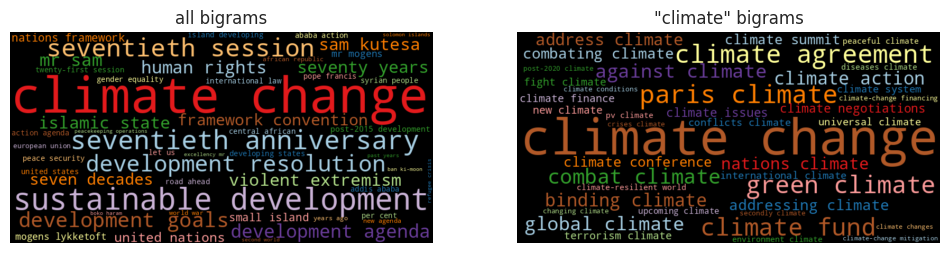

In [71]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

# Comparing Frequencies across Time-Intervals and Categories


## Creating Frequency Timelines


In [72]:
def count_keywords(tokens, keywords):

  tokens = [t for t in tokens if t in keywords]
  counter = Counter(tokens)
  return [counter.get(k, 0) for k in keywords]

In [73]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

count_keywords(tokens, keywords)

[1, 0, 3, 2]

In [74]:
def count_keywords_by(df, by, keywords, column='tokens'):

  df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
  freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
  freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
  freq_df[by] = df[by] # copy the grouping column(s)

  return freq_df.groupby(by=by).sum().sort_values(by)

In [75]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [76]:
freq_df

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266
1974,478,24,71,316
1975,578,20,53,232
1976,451,146,57,347
1977,675,75,58,321
1978,550,82,52,309


In [77]:
pd.options.display.max_rows = 4

In [78]:
pd.options.display.max_rows = 60

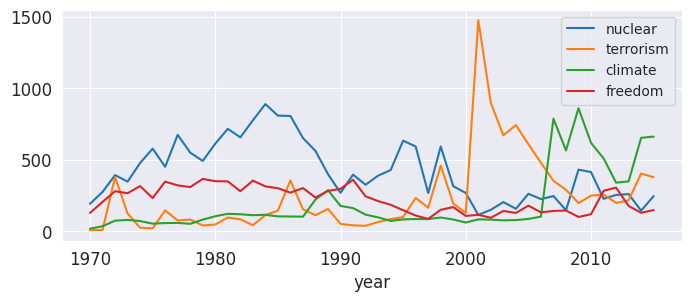

In [79]:
freq_df.plot(kind='line', figsize=(8, 3));

In [80]:
random.seed(23) ###
# analyzing mentions of 'climate' before 1980
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=5)

  0%|          | 0/1245 [00:00<?, ?it/s]

5 random samples out of 581 contexts for 'climate':
ation with a view to replacing the   climate   of fear, mistrust and hatred by to
ntributing to the maintenance of a   climate   of peace, harmony and understandin
ges in the international political   climate  . There is increasing awareness of 
rian-Israeli front, have created a   climate   which favors the continuation of n
 that, far from noting a promising   climate   in the most critical areas of inte


## Creating Frequency Heat Maps


  0%|          | 0/7507 [00:00<?, ?it/s]

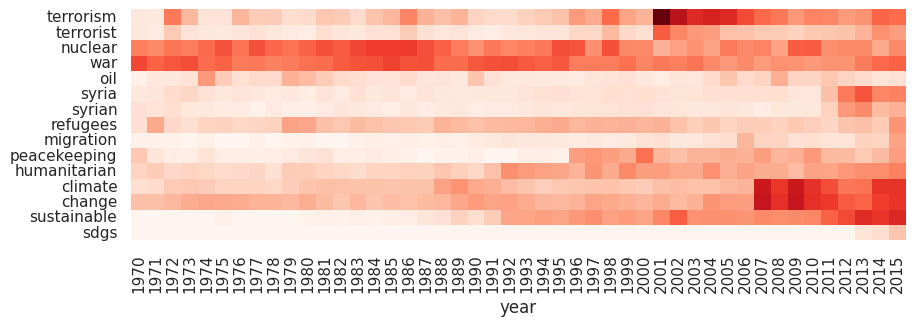

In [81]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping',
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3)) ###
sns.set(font_scale=1) ###
sns.heatmap(data=freq_df.T,
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1) ###